# Experiment 2: Breast repositioning with different wavelengths

#### Author: 
Bruno De Santi, PhD
#### Affiliation:
Multi-modality Medical Imaging Lab (M3I Lab), University of Twente, Enschede, The Netherlands
#### Date:
20/09/2023
#### Paper/Project Title:
Automated three-dimensional image registration for longitudinal photoacoustic imaging (De Santi et al. 2023, JBO)
#### GitHub:
https://github.com/brunodesanti/muvinn-reg
#### License:
[Specify the license, e.g., MIT, GPL, etc.]

### Import libraries

In [ ]:
abs_path = r'C:\Users\DeSantiB\muvinn-reg'
import sys
sys.path.append(abs_path)

from models import models
from utils import processing as proc
from utils import visualizing as vis
from utils import evaluating as eva

import matplotlib.pyplot as plt
import numpy as np
import os 
import torch
import time
import scipy.ndimage as scnd
import SimpleITK as sitk

plot_flag = True # if one wants to plot figures
save_flag = True # if one wants to save figures

### Apply MUVINN-reg and save results

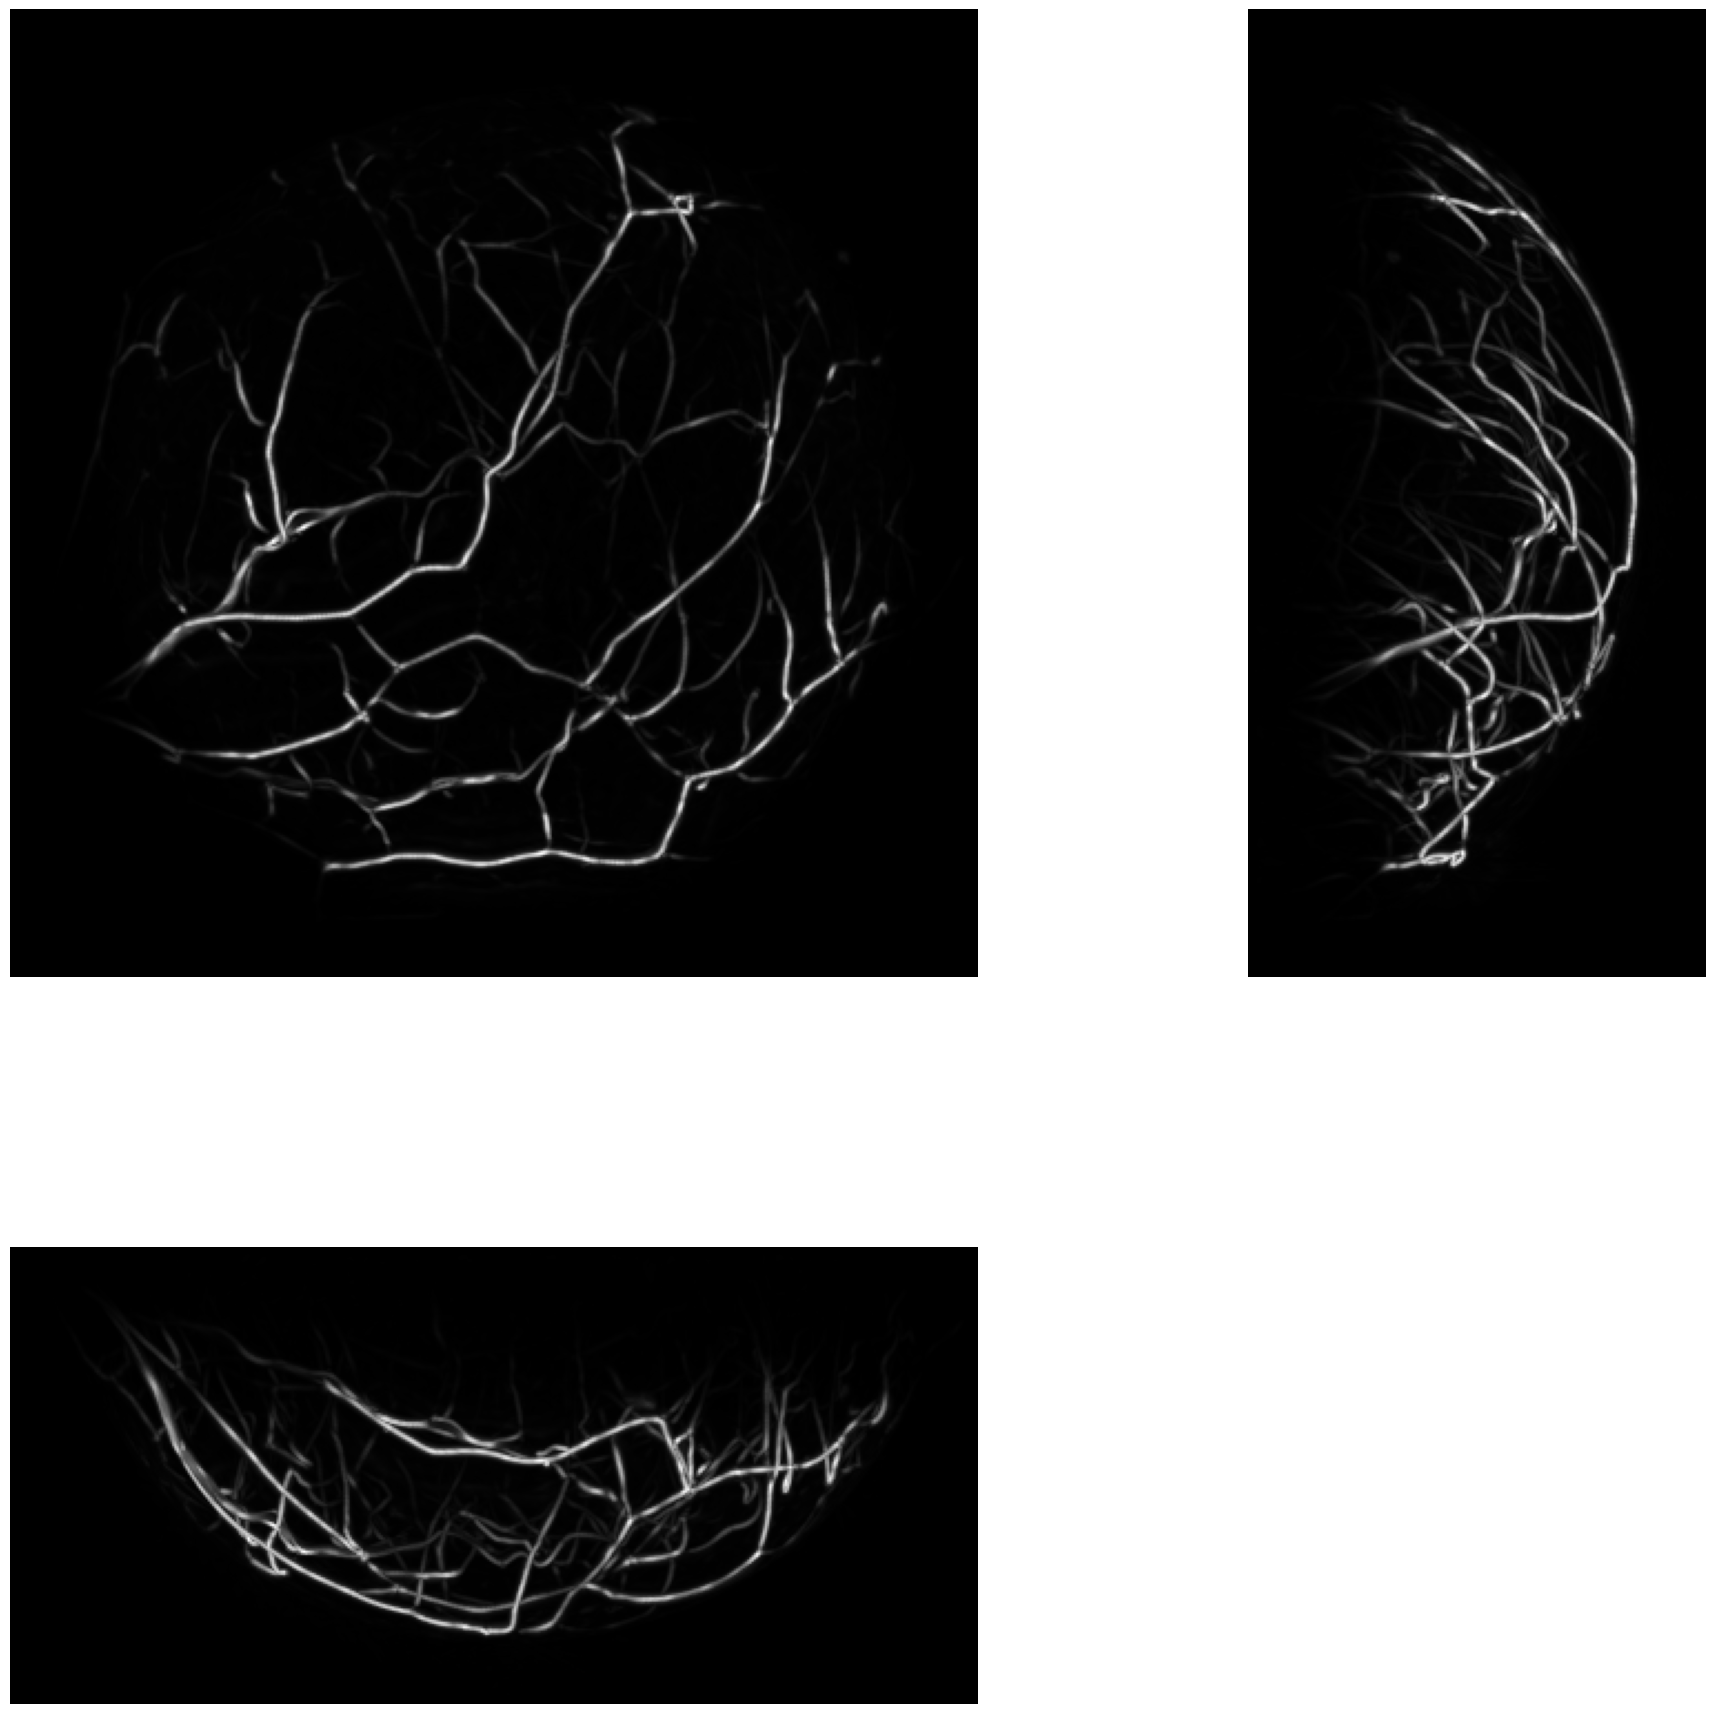

In [8]:
# Data path
data_path = r'path\to\data'

# Path to directory where landmarks are stored
landmarks_path = r'C:\Users\DeSantiB\muvinn-reg\notebooks\mevislab\landmarks'

# Load and pad fixed image
fixed_acq = '01_01'
fixed_path = data_path + os.path.sep + fixed_acq + '.npy'
fixed_data = np.load(fixed_path, allow_pickle=True).item()
fixed_image = proc.pad_rec(fixed_data["rec"], ((3, 3), (3, 3),(3, 3)))

# Pad depth map and cup mask
depth_map = proc.pad_rec(fixed_data["depth_map"], ((3, 3), (3, 3),(3, 3)))
cup_mask = proc.pad_rec(fixed_data["cup_mask"], ((3, 3), (3, 3),(3, 3)))

# Processing fixed image for image visualization
frangi_options_pp = dict()
frangi_options_pp['sigmas'] = (2, 3, 4)
frangi_options_pp['alpha'] = 0.5
frangi_options_pp['beta'] = 0.5
frangi_options_pp['gamma'] = 1
frangi_options_pp['bw_flag'] = True  

aim_options_pp = dict()
aim_options_pp['half_size_win'] = 5
aim_options_pp['min_sd'] = 0.1
aim_options_pp['weights'] = (0.2, 0.8)

_, _ , fixed_image_pp = proc.processing_vis(fixed_image, frangi_options_pp, aim_options_pp, gpu = 'cuda') 

# Plot and save fixed image MIPs
if plot_flag:
    plt.figure()
    fig = vis.plot_mips(fixed_image)
    fig.tight_layout()
    if save_flag:
        fig.savefig(r'image_{}.svg'.format(fixed_acq),dpi = 600)
        fig.savefig(r'image_{}.png'.format(fixed_acq))

    plt.figure()
    fig = vis.plot_mips(fixed_image_pp)
    fig.tight_layout()
    if save_flag:
        fig.savefig(r'pp_image_{}.svg'.format(fixed_acq), dpi=600)
        fig.savefig(r'pp_image_{}.png'.format(fixed_acq))
        
# Adaptive thresholding for vascular segmentation of fixed image
ti = 0.008 # threshold at cup surface
tf = 0.003 # threshold at maximum depth
tau = 100 # decay rate
fixed_mask = proc.segment_vessels(fixed_image_pp, depth_map, ti = ti, tf = tf, tau = tau)

# Define sampling mask
sample_mask = np.bitwise_and(scnd.binary_dilation(cup_mask, np.ones((3, 3, 3))), scnd.binary_dilation(fixed_mask, np.ones((1, 1, 1))))

# Convert to CUDA tensor
fixed_image_t = torch.FloatTensor(fixed_image).cuda()

moving_acqs = ('02_02','03_02')
for moving_acq in moving_acqs:
    
    # Load and pad moving image
    moving_path = data_path + os.path.sep + moving_acq + '.npy'
    moving_data = np.load(moving_path, allow_pickle = True).item() #item() to return each item in tuples
    moving_image = proc.pad_rec(moving_data["rec"], ((3, 3), (3, 3),(3, 3)))

    # Process moving image
    _, _ , moving_image_pp = proc.processing_vis(moving_image, frangi_options_pp, aim_options_pp, gpu = 'cuda')
       
    # Plot and save moving image MIPs
    if plot_flag:
        plt.figure()
        fig = vis.plot_mips(moving_image)
        fig.tight_layout()
        if save_flag:
            fig.savefig(r'image_{}.svg'.format(moving_acq),dpi = 600)
            fig.savefig(r'image_{}.png'.format(moving_acq))
        
        plt.figure()
        fig = vis.plot_mips(moving_image_pp)
        fig.tight_layout()
        if save_flag:
            fig.savefig(r'pp_image_{}.svg'.format(moving_acq), dpi=600)
            fig.savefig(r'pp_image_{}.png'.format(moving_acq))
            
    # Convert to CUDA tensor
    moving_image_t = torch.FloatTensor(moving_image).cuda()
    
    # MUVINN-reg settings and parameters
    kwargs = {}
    kwargs['mask'] = sample_mask

    # Number of epochs
    kwargs['epochs'] = 20000
    # Total number of points to be sampled each iteration
    kwargs['batch_size'] = 200 * (5 ** 3)
    
    # Sigma values during optimization
    kwargs['frangi_sigmas'] = np.array([12, 9, 5, 3, 1.5])
    
    # Epochs for each sigma as percentage of total number of epochs
    frangi_interval = np.array([0.2, 0.2, 0.2, 0.2, 0.2]) 
    kwargs['frangi_epochs'] = np.insert(np.cumsum(np.floor(frangi_interval*kwargs['epochs']))[:-1],0,0)

    # Data term loss function
    kwargs['loss_function'] = 'ncc'
    # Width of local patches around sampled points
    kwargs['ncc_widths'] = 2.5*kwargs['frangi_sigmas']/100

    # Regularization
    kwargs['jacobian_regularization'] = True
    kwargs['alpha_jacobian'] = 1
    kwargs['hyper_regularization'] = False
    kwargs['alpha_hyper'] = 0.25

    # Network architecture
    kwargs['layers'] = [3,300,300,300,300,300,300,3]
    kwargs['omega'] = 30

    # Optimizer settings
    kwargs['optimizer'] = 'adam' 
    kwargs['lr'] = 5e-5
    
    # Decrease learning rate when decreasing sigma
    kwargs['scheduler_ms'] = kwargs['frangi_epochs'] # MultiStepLR scheduler parameters
    kwargs['scheduler_gamma'] = 0.95

    # If true print results during optimization
    kwargs['verbose'] = False 
    # Folder where to save verbose results if verbose is true
    kwargs['save_folder'] = r'C:\Users\DeSantiB\muvinn-reg\notebooks\verbose'
    # Verbose interval in epochs
    kwargs['log_interval'] = int(kwargs['epochs']/4)
    
    # Frangi parameters inside optimization
    frangi_options = dict()
    frangi_options['alpha'] = 0.5
    frangi_options['beta'] = 0.5
    frangi_options['gamma'] = 0.1
    frangi_options['bw_flag'] = True # White voxels are vessels
    kwargs['frangi_options'] = frangi_options
    
    # Adaptive intensity modulation parameters inside optimization
    aim_options = dict()
    aim_options['half_size_win'] = 5
    aim_options['min_sd'] = 0.1

    start_time = time.time()
    # Initialize model
    ImpReg = models.ImplicitRegistrator(moving_image_t, fixed_image_t, **kwargs)
    # Run model optimization
    ImpReg.train()
    execution_time = time.time() - start_time
    
    # Save and plot loss curve
    fig = plt.figure(figsize = (20,5))
    plt.plot(ImpReg.data_loss_list) # loss curve
    plt.xlim(xmin=0, xmax = kwargs['epochs'])
    plt.ylim(ymin=-1, ymax = 0)
    ax = plt.gca()
    plt.grid()
    fig.savefig(r'loss_muvinn_{}_{}.svg'.format(fixed_acq, moving_acq), dpi = 600)
    fig.savefig(r'loss_muvinn_{}_{}.png'.format(fixed_acq, moving_acq))
    
    # Evaluation is conducted on the corresponding 720 nm of moving image
    
    # Load and crop moving image at 720 nm
    moving_ev_acq = moving_acq.split('_')[0] + '_01'
    moving_ev_path = data_path + os.path.sep + moving_ev_acq + '.npy'
    moving_ev_data = np.load(moving_ev_path, allow_pickle = True).item() #item() to return each item in tuples
    moving_ev_image = proc.pad_rec(moving_ev_data["rec"], ((3, 3), (3, 3),(3, 3)))
    
    # Convert to CUDA tensor
    moving_ev_image_t = torch.FloatTensor(moving_ev_image).cuda()

    # Process image
    _, _ , moving_ev_image_pp = proc.processing_vis(moving_ev_image, frangi_options_vis, aim_options_vis, gpu = 'cuda')
    
    # Vascular segmentation
    moving_ev_mask = proc.segment_vessels(moving_ev_image_pp, depth_map, ti = ti, tf = tf, tau = tau)

    # Transform both original and processed 720 nm
    transformed_ev_image, transformed_ev_mask = ImpReg(fixed_image.shape, moving_ev_image_t, moving_ev_mask, forward_batch_size = 50000)
    transformed_ev_image_pp = ImpReg(fixed_image.shape, torch.FloatTensor(moving_ev_image_pp).cuda(), forward_batch_size = 50000) # pp=pre-processed
    
    # Plot and save RGB overlays before and after co-registration
    if plot_flag:
        plt.figure()
        fig = vis.plot_aligned_mips(moving_ev_image_pp, fixed_image_pp, alpha = 0.5)
        fig.tight_layout()
        if save_flag:
            fig.savefig(r'overlay_pp_{}_{}.svg'.format(fixed_acq, moving_ev_acq), dpi=600)
            fig.savefig(r'overlay_pp_{}_{}.png'.format(fixed_acq, moving_ev_acq))

        plt.figure()
        fig = vis.plot_aligned_mips(transformed_ev_image_pp, fixed_image_pp)
        fig.tight_layout()
        if save_flag:
            fig.savefig(r'muvinn_overlay_{}_{}.svg'.format(fixed_acq, moving_ev_acq), dpi = 600)
            fig.savefig(r'muvinn_overlay_{}_{}.png'.format(fixed_acq, moving_ev_acq))
            
    # Plot and save RGB overlays at different depths after co-registration
    if plot_flag:
        depths = (4, 2, 0)
        figs = vis.plot_aligned_mips_depth(moving_image_pp, fixed_image_pp, depth_map, depths, alpha = 0.5)
        if save_flag:
            for i, fig in enumerate(figs):
                fig.savefig(r'overlay_depth_{}_{}_{}.svg'.format(depths[i], fixed_acq, moving_acq), dpi = 600)
                fig.savefig(r'overlay_depth_{}_{}_{}.png'.format(depths[i], fixed_acq, moving_acq))

        figs = vis.plot_aligned_mips_depth(transformed_image_pp, fixed_image_pp, depth_map, depths, alpha = 0.5)
        if save_flag:
            for i, fig in enumerate(figs):
                fig.savefig(r'muvinn_overlay_depth_{}_{}_{}.svg'.format(depths[i], fixed_acq, moving_acq), dpi = 600)
                fig.savefig(r'muvinn_overlay_depth_{}_{}_{}.png'.format(depths[i], fixed_acq, moving_acq))
            
    # Quantitative evaluation
 
    # Before co-registration
    images = dict()
    images['fixed'] = fixed_image
    images['moving'] = moving_ev_image

    masks = dict()
    masks['fixed'] = fixed_mask
    masks['moving'] = moving_ev_mask
    
    fixed_landmarks, moving_landmarks = eva.load_landmarks(landmarks_path, fixed_acq, moving_ev_acq)
    landmarks = dict()
    landmarks['reg'] = fixed_landmarks
    landmarks['gt'] = moving_landmarks

    metrics_before = eva.similarity(images, masks, landmarks)
    
    # Save metrics before co-registration
    np.save(r'metrics_before_{}_{}.npy'.format(fixed_acq, moving_ev_acq), metrics_before) 
    
    # After co-registration
    images = dict()
    images['fixed'] = fixed_image
    images['moving'] = transformed_ev_image

    masks = dict()
    masks['fixed'] = fixed_mask
    masks['moving'] = transformed_ev_mask

    # Transform landmarks
    reg_landmarks, delta = eva.register_landmarks(ImpReg.network, fixed_landmarks, fixed_image.shape)

    landmarks = dict()
    landmarks['reg'] = reg_landmarks
    landmarks['gt'] = moving_landmarks
    
    if save_flag:
        str_landmarks = str()
        idx_landmark = 1
        str_landmarks +=  '['
        for landmark in reg_landmarks:
            str_landmark = '(' + str(landmark[2]) + ' ' + str(landmark[1]) + ' ' + str(landmark[0]) + ')' + '  #{},'. format(idx_landmark)
            str_landmarks +=  str_landmark
            idx_landmark += 1
        str_landmarks +=  ']'
        with open('reg_points_{}_{}.txt'.format(fixed_acq, moving_ev_acq), 'w') as f:
            f.write(str_landmarks)

    metrics_after = eva.similarity(images, masks, landmarks)
    
    # Save metrics after co-registration
    np.save(r'metrics_after_{}_{}.npy'.format(fixed_acq, moving_ev_acq), metrics_after) 
    
    # Save execution time
    np.save(r'execution_time_{}_{}.npy'.format(fixed_acq, moving_acq), execution_time)

    # Extract displacement field
    coordinate_tensor = ImpReg.makeCoordinateTensor(fixed_image.shape)
    displacement_field = eva.displacement_field(ImpReg.network, coordinate_tensor, fixed_image.shape, forward_batch_size = 30000)

    # Mask displacement field using cup mask
    displacement_field_x = displacement_field[:,:,:,0]
    displacement_field_y = displacement_field[:,:,:,1]
    displacement_field_z = displacement_field[:,:,:,2]
    masked_displacement_field_x = np.zeros_like(displacement_field_x)
    masked_displacement_field_y = np.zeros_like(displacement_field_x)
    masked_displacement_field_z = np.zeros_like(displacement_field_x)
    masked_displacement_field_x[np.where(cup_mask)] = displacement_field_x[np.where(cup_mask)]
    masked_displacement_field_y[np.where(cup_mask)] = displacement_field_y[np.where(cup_mask)]
    masked_displacement_field_z[np.where(cup_mask)] = displacement_field_z[np.where(cup_mask)]
        
    # Compute magnitude of displacement field
    magnitude_displacement_field = np.sqrt(masked_displacement_field_x**2 + masked_displacement_field_y**2 + masked_displacement_field_z**2)
    if save_flag:
        # Save displacement field
        np.save(r'mag_df_{}_{}.npy'.format(fixed_acq, moving_acq), np.float16(magnitude_displacement_field)) 